# Polymarket



In [ ]:
# @title
!pip install requests nltk


In [2]:
# @title
import pandas as pd
import json
import requests
import random
import re
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import importlib

# Force-reload NLTK in case it was partially initialized
import nltk
importlib.reload(nltk)
from nltk.corpus import movie_reviews
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords

from nltk.classify import SklearnClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix

# Get tags.csv

In [ ]:
# Get all tags

all_tags = []
limit = 100
offset = 0

while True:
    r = requests.get("https://gamma-api.polymarket.com/tags", params={"limit": limit, "offset": offset})
    tags = r.json()
    if not tags:
        break
    all_tags.extend(tags)
    offset += limit


In [ ]:
# Write into a CSV

df_tags = pd.DataFrame(all_tags)
df_tags = df_tags[["id","label","slug"]]

df_tags = df_tags.to_csv("tags.csv", index=False)

# Get events.csv

In [3]:
# Get all events

all_events = []
limit = 100
offset = 0

while True:
    r = requests.get("https://gamma-api.polymarket.com/events?open=true&closed=false", params={"limit": limit, "offset": offset})
    events = r.json()
    if not events:
        break
    all_events.extend(events)
    offset += limit

In [4]:
df_event = pd.DataFrame(all_events)
df_event = df_event[['id','slug','title','tags','description','startDate','liquidity','commentCount','markets','volume24hr', 'volume1wk', 'volume1mo', 'volume1yr']]
df_event = df_event.to_csv("events.csv", index=False)

In [6]:
# Correlation between commentCount and volume1yr

# Check if df_event is None due to previous cell's operation and reload if necessary
# The root cause is in cell e4SGA5TbQwiK, where df_event was reassigned by .to_csv()
if 'df_event' not in locals() or df_event is None:
    try:
        df_event = pd.read_csv("events.csv")
    except FileNotFoundError:
        print("Error: events.csv not found. Please ensure the previous cells ran successfully.")
        raise # Re-raise the error if the file isn't found

commentCount = df_event['commentCount']
volume1yr = df_event['volume1yr']

correlation = commentCount.corr(volume1yr)
print(correlation)

0.0911407360939759


# Create event_tags.csv

In [ ]:
all_event_tags = []

for event in all_events:
    if 'tags' in event and event['tags']:
        for tag in event['tags']:

            all_event_tags.append({
            "tag_id" : tag['id'],
            "label" : tag['label'],
            "slug" : tag['slug'],
            "event_id" : event['id']
            })

df_event_tags = pd.DataFrame(all_event_tags)
df_event_tags = df_event_tags.to_csv("event_tags.csv", index=False)

# Sentiment Analysis

In [ ]:
# Get all comments for "Democratic Presidential Nominee 2028: Will Oprah Winfrey "

all_comments = []
limit = 100
offset = 0
parent_entity_id = 30829

while True:
    r = requests.get("https://gamma-api.polymarket.com/comments?parent_entity_type=Event&get_positions=true", params={"parent_entity_id": parent_entity_id, "limit": limit, "offset": offset})
    comments = r.json()
    if not comments:
        break
    all_comments.extend(comments)
    offset += limit

all_comments

# Organizing comment info
all_user_positions = []
comment_raw = []

for comment in all_comments:
    comment_id = comment.get("id")
    comment_body = comment.get("body")
    positions = comment.get("profile", {}).get("positions", [])

    for pos in positions:
        all_user_positions.append({
            "comment_id": comment_id,
            "comment_body": comment_body,
            **pos
        })
        comment_raw.append(comment_body)

df_user_positions = pd.DataFrame(all_user_positions)
df_user_positions["positionSize"] = df_user_positions["positionSize"].astype(float)
df_user_positions["positionSize"] = df_user_positions["positionSize"]/1000000

df_user_bet_id = df_user_positions["comment_id"]

# Cheated here
df_user_positions["position"] = df_user_positions["tokenId"].apply(lambda x: 1 if x == df_user_positions['tokenId'].loc[254] else 0)
print("This event has", df_user_positions.shape[0],"comments for the model training.")

This event has 2083 comments for the model training.


In [ ]:
def load_dataset():
  documents = []

  # Iterate over the DataFrame to get comment_body and the derived 'position' (Yes/No sentiment)
  for index, row in df_user_positions.iterrows():
      comment_body = row["comment_body"]
      position = row["position"]
      documents.append((comment_body, position))

  random.seed(42)
  random.shuffle(documents)
  return documents

raw_documents = load_dataset()

In [ ]:
nltk.download('punkt_tab')
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('stopwords')
lemmatizer = WordNetLemmatizer()

stopword_custom = {'the','is','to','and','of','it','you','this','pls','in','are','be'}
stop_words = set(STOPWORDS) | set(stopwords.words('english')) | stopword_custom

#Tokenize and remove stopwords.
def preprocess_text(text):
  text = str(text).lower() #Ensure text is String typed and lowercased.
  text = re.sub(r"http\S+|www\S+|https\S+", " ", text) #Remove URLs (\S+ = one or more non-whitespace chars).
  text = re.sub(r"@\w+", " ", text) #Remove @mentions. (\w+ = one or more "word" characters (letters, digits, underscore)).
  text = re.sub(r"#", " ", text) #Remove hashtags.
  text = re.sub(r"[^a-z0-9\s%]", " ", text) #Keep lowercase letters (a-z), digits (0-9), whitespacenewline - space/tab/ (\s) and percentage (%).
  text = re.sub(r"\s+", " ", text).strip() #Replace any run of whitespace with a single space, and trim the ends (remove leading/trailing spaces).
  tokens = text.split() #Tokenize.
  tokens = [t for t in tokens if t not in stop_words and len(t) > 2]
  return tokens

# Converts raw documents into tokenized documents with labels
def prepare_documents(raw_documents):
  process_docs = []
  for text, label in raw_documents:
    tokens = preprocess_text(text)
    process_docs.append((tokens, label))
  return process_docs

processed_documents = prepare_documents(raw_documents)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
import random

def split_data(data, ratio=0.8):
    # Separate data by label
    data_0 = [item for item in data if item[1] == 0]
    data_1 = [item for item in data if item[1] == 1]

    # Calculate split points for each label
    split_0 = int(len(data_0) * ratio)
    split_1 = int(len(data_1) * ratio)

    # Split data for each label
    train_0, test_0 = data_0[:split_0], data_0[split_0:]
    train_1, test_1 = data_1[:split_1], data_1[split_1:]

    # Combine and shuffle the training and testing sets
    train_data = train_0 + train_1
    test_data = test_0 + test_1

    random.shuffle(train_data)
    random.shuffle(test_data)

    return train_data, test_data

train_data, test_data = split_data(processed_documents)

In [ ]:
def build_vocab(documents, top_n = 5000):
  freq = Counter()
  for tokens, _ in documents:
    freq.update(tokens)
  return [w for w, _ in freq.most_common(top_n)]

def featurize(tokens, vocab):
  counts = Counter(tokens)
  return {w: counts.get(w,0) for w in vocab}

print("Building Vocab...")
vocab = build_vocab(train_data, top_n = 5000)

train_set = [(featurize(t, vocab), l) for t, l in train_data]
test_set = [(featurize(t, vocab), l) for t, l in test_data]

Building Vocab...


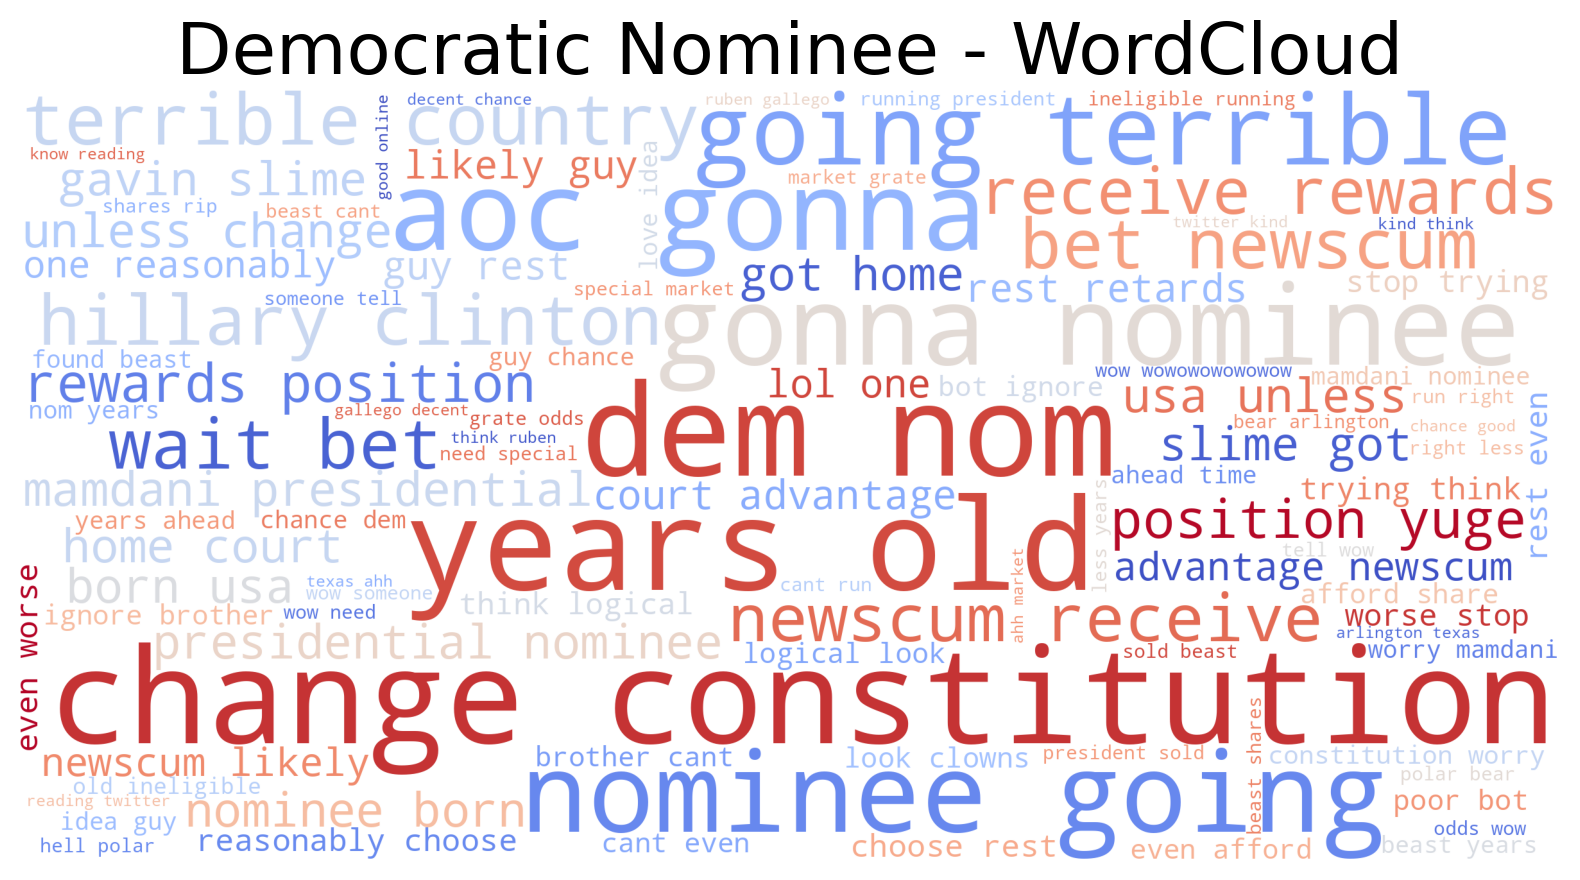

In [ ]:
flatten_tokens = [token for tokens, _ in processed_documents for token in tokens]
raw_documents = ' '.join(flatten_tokens)

demo_wordcloud = WordCloud(width=2400, height=1200, background_color='white', max_words=100, colormap='coolwarm', collocations=True).generate(raw_documents)

plt.figure(figsize=(10, 5), dpi=200)
plt.imshow(demo_wordcloud)
plt.axis('off')
plt.title("Democratic Nominee - WordCloud", fontsize=26)
plt.show()

In [ ]:
classifier = SklearnClassifier(MultinomialNB(alpha = 0.5))
classifier.train(train_set)

<SklearnClassifier(MultinomialNB(alpha=0.5))>

In [ ]:
y_true, y_pred = [], []
for feats, label in test_set:
  y_true.append(label)
  y_pred.append(classifier.classify(feats))

confusion_matrix = nltk.ConfusionMatrix(y_true, y_pred)
print(confusion_matrix)
print(classification_report(y_true, y_pred))

  |   0   1 |
--+---------+
0 |<378> 33 |
1 |   4  <3>|
--+---------+
(row = reference; col = test)

              precision    recall  f1-score   support

           0       0.99      0.92      0.95       411
           1       0.08      0.43      0.14         7

    accuracy                           0.91       418
   macro avg       0.54      0.67      0.55       418
weighted avg       0.97      0.91      0.94       418



In [ ]:
# Get all comments for "Democratic Presidential Nominee 2028: Will Gavin Newsome be elected as Presidential Candidate? "

all_comments = []
limit = 100
offset = 0
parent_entity_id = 30829

while True:
    r = requests.get("https://gamma-api.polymarket.com/comments?parent_entity_type=Event", params={"parent_entity_id": parent_entity_id, "limit": limit, "offset": offset})
    comments = r.json()
    if not comments:
        break
    all_comments.extend(comments)
    offset += limit

# Organizing comment info
all_user_positions = []

for comment in all_comments:
    comment_id = comment.get("id")
    comment_body = comment.get("body")

    all_user_positions.append({
        "comment_id": comment_id,
        "comment_body": comment_body
        })

df_user_positions = pd.DataFrame(all_user_positions)


df_comments_without_bets = df_user_positions[~df_user_positions["comment_id"].isin(df_user_bet_id)]
df_comments_without_bets

,comment_id,comment_body
1,2394983,The sell-wall is fake. It's meant to keep the ...
2,2393942,Whale clusters are rotating out of the favorit...
5,2394749,sharp money positioning heavy on this one
6,2386527,Something shifted in the dark flow 10 minutes ...
7,2383501,The volume-to-wallet ratio is insane. This mov...
...,...,...
496,1749215,Is that LeBron James?
497,1749213,great markets
499,1735875,Jeez when you put it like that... congratulati...
501,1735862,For the record: I was first person to buy Gavi...


In [ ]:
# Function to predict sentiment for a given text
def predict_sentiment(text, classifier, vocab):
    processed_tokens = preprocess_text(text)
    featurized_text = featurize(processed_tokens, vocab)
    return classifier.classify(featurized_text)

# Apply the prediction function to each comment in df_comments_without_bets
df_comments_without_bets['predicted_position'] = df_comments_without_bets['comment_body'].apply(lambda x: predict_sentiment(x, classifier, vocab))

# Display the DataFrame with the new predicted_position column
# Corrected line to filter for rows where 'predicted_position' is 1
df_comments_without_bets

/tmp/ipython-input-3976864159.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_comments_without_bets['predicted_position'] = df_comments_without_bets['comment_body'].apply(lambda x: predict_sentiment(x, classifier, vocab))


,comment_id,comment_body,predicted_position
1,2394983,The sell-wall is fake. It's meant to keep the ...,0
2,2393942,Whale clusters are rotating out of the favorit...,0
5,2394749,sharp money positioning heavy on this one,0
6,2386527,Something shifted in the dark flow 10 minutes ...,0
7,2383501,The volume-to-wallet ratio is insane. This mov...,0
...,...,...,...
496,1749215,Is that LeBron James?,0
497,1749213,great markets,0
499,1735875,Jeez when you put it like that... congratulati...,0
501,1735862,For the record: I was first person to buy Gavi...,1


In [ ]:
## Gavin Newsome Stats
(df_user_positions['position'].value_counts() + df_comments_without_bets['predicted_position'].value_counts())

,count
position,
0,2333
1,99


In [ ]:
print(99/(2333+99))
print(2333/(2333+99))

0.04070723684210526
0.9592927631578947
